### Import external modules

In [1]:
import pandas as pd 
import numpy as np 
import sqlite3
import random
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import itertools
import json

### Load data

In [2]:
def load_data(db_name, table_name): # Connect to db and read data from it
    db_conn = sqlite3.connect(db_name)
    
    data_df =  pd.read_sql_query(f"SELECT * FROM {table_name}", db_conn)

    import io
    import PIL
    from keras.preprocessing.image import img_to_array

    bytes_to_image = lambda data: img_to_array(PIL.Image.open(io.BytesIO(data)).convert('L'))

    return data_df['label'].to_numpy(), np.array([bytes_to_image(img) for img in data_df['image'].to_numpy()]);

In [3]:
labels, images = load_data('fruitrient_db', 'data_df')

### Process data

In [4]:
def process_data(X_data, y_data):
    
    #Normalize the pixels
    X_data = X_data / 255
    
    # Split the dataset into 72% training data, 18% validation data and 10% testing data
    X, X_test, y, y_test = train_test_split(X_data,y_data,test_size=0.1,random_state = 123)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2,random_state = 123)
    
    return X_train, y_train, X_val, y_val, X_test, y_test;

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = process_data(images, labels)

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7303, 100, 100, 1)
(1826, 100, 100, 1)
(1015, 100, 100, 1)
(7303,)
(1826,)
(1015,)


### Build model

In [7]:
def build_model(X_train, y_train, X_val, y_val, nb_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, 
                   kernel_size=(3,3), 
                   padding="same",
                   input_shape=(100, 100, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64,
                   kernel_size=(3,3),
                   padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(filters=128,
                   kernel_size=(3,3),
                   padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    model.summary()
    
    
    return model;

In [8]:
model = build_model(X_train, y_train, X_val, y_val, 6)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       7

### Train model

In [49]:
def train_model(model, nb_epochs):
    history = model.fit(X_train, y_train, epochs=nb_epochs, validation_data=(X_val, y_val))
    
    return model, history;

In [50]:
model, history = train_model(model, 5)

Epoch 1/5
229/229 [==============================] - 70s 306ms/step - loss: 1.0856 - accuracy: 0.5702 - val_loss: 0.7527 - val_accuracy: 0.7097
Epoch 2/5
229/229 [==============================] - 62s 271ms/step - loss: 0.6625 - accuracy: 0.7479 - val_loss: 0.6150 - val_accuracy: 0.7634
Epoch 3/5
229/229 [==============================] - 61s 268ms/step - loss: 0.5480 - accuracy: 0.7913 - val_loss: 0.5283 - val_accuracy: 0.7979
Epoch 4/5
229/229 [==============================] - 62s 271ms/step - loss: 0.4101 - accuracy: 0.8439 - val_loss: 0.4397 - val_accuracy: 0.8308
Epoch 5/5
229/229 [==============================] - 62s 271ms/step - loss: 0.3215 - accuracy: 0.8796 - val_loss: 0.3653 - val_accuracy: 0.8675


<Figure size 432x288 with 0 Axes>

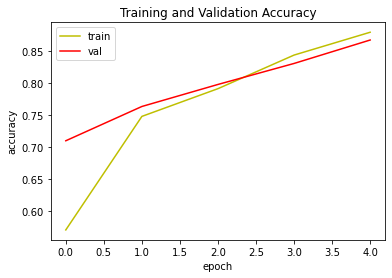

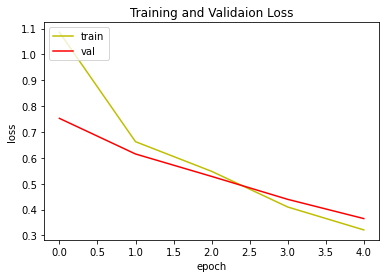

<Figure size 432x288 with 0 Axes>

In [51]:
# Plot the accuracy and loss throughout the epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'y')
plt.plot(epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'y')
plt.plot(epochs, val_loss, 'r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

### Evaluate model

In [52]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)
    

In [53]:
evaluate_model(model, X_test, y_test)

32/32 [==============================] - 2s 58ms/step - loss: 0.3696 - accuracy: 0.8631


[0.3696078062057495, 0.8630542159080505]

### Make predictions

In [54]:
def make_predictions(model, X_test):
    prediction = model.predict(X_test) # Makes predicitons for each example in the test dataset
    pred_classes=np.argmax(prediction,axis=1)
    
    return pred_classes;

In [55]:
pred_classes = make_predictions(model, X_test)

### Assess model performance

In [56]:
def assess_model(true_classes, predictied_classes):
     print(classification_report(true_classes, predictied_classes))

        

In [57]:
assess_model(y_test, pred_classes)

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       143
         1.0       0.69      0.84      0.76       166
         2.0       0.84      0.81      0.83       168
         3.0       0.97      0.95      0.96       176
         4.0       0.98      0.98      0.98       134
         5.0       0.87      0.79      0.83       228

    accuracy                           0.86      1015
   macro avg       0.87      0.87      0.87      1015
weighted avg       0.87      0.86      0.86      1015



### Visualization of images along with their true and predicted classes

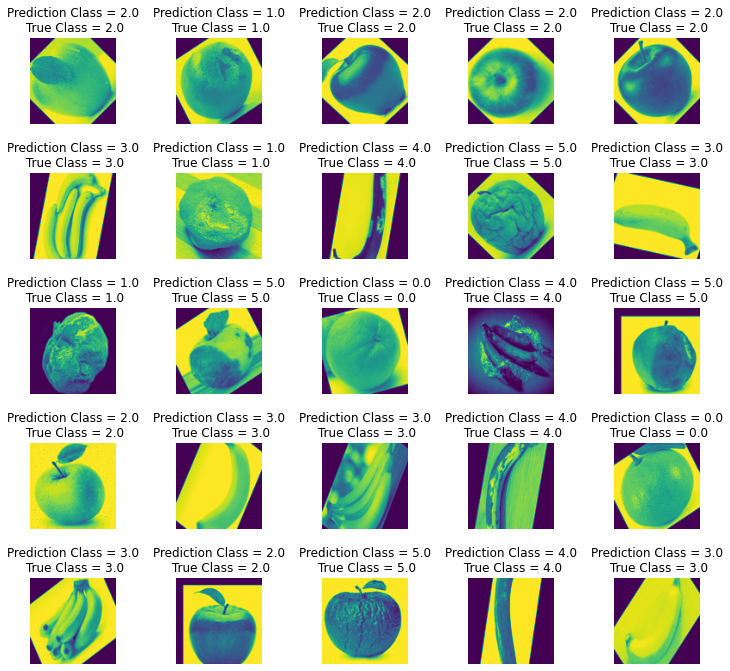

In [59]:
# Create arrays from test dataframes for manual tesing purposes
X_test_arr = np.array(X_test, dtype = 'float32')
y_test_arr = np.array(y_test, dtype = 'float32')

#Visualization of images along with their true and prectied class
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel() # 

for i in np.arange(0, L * W): 
    
    random_number = np.random.randint(0, len(y_test_arr))  
    axes[i].imshow(X_test_arr[random_number].reshape(100,100))
    axes[i].set_title("Prediction Class = {:0.1f}\n True Class = {:0.1f}".format(pred_classes[random_number], y_test_arr[random_number]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.7)

### Confusion Matrix

In [60]:
 cm = confusion_matrix(y_test, pred_classes)

In [61]:
# A funcition provided by ScikitLearn to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.title('Confusion Matrix', fontsize=16)

In [9]:
# Get the corresponding names for each fruit label to display them in the matrix
with open('./fruits-labels.json') as read_file:
    fruits_labels = json.load(read_file)

labels = []
typ = fruits_labels.get('type')
for i in typ:
    labels.append(i)

Confusion matrix, without normalization
[[120  16   6   0   1   0]
 [  6 140   4   2   0  14]
 [  6  14 136   1   0  11]
 [  2   3   0 168   1   2]
 [  1   0   0   2 131   0]
 [  3  29  15   0   0 181]]


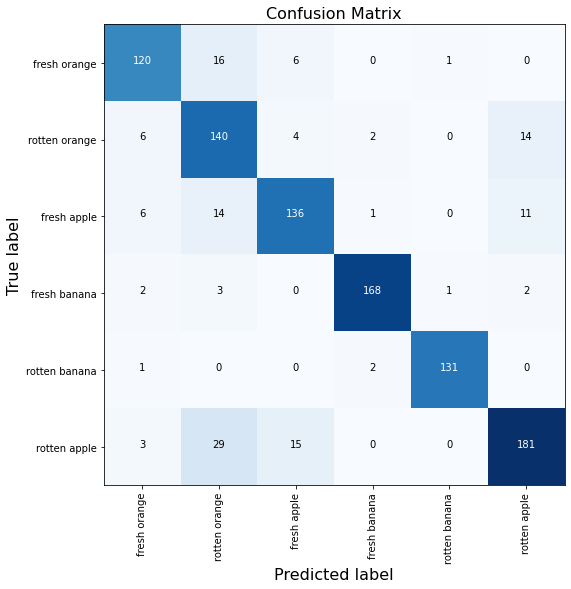

In [63]:
# Plot the confusion matrix
plt.figure(figsize=(8, 8))

plot_confusion_matrix(cm=cm, classes=labels)

### Save the model

In [65]:
model.save('cnn_grayscale_model.h5') 